In [1]:
!pip install datasets
!pip install pythainlp
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 41.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Machine Translation + Transformer

In [3]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [4]:
# !pip install -U portalocker --user

In [5]:
# torch.cuda.get_device_name(0)

In [6]:
torch.__version__

'2.1.0+cu121'

In [7]:
torchtext.__version__

'0.16.0+cpu'

## 1. ETL: Loading the dataset

In [8]:
# from torchtext.datasets import Multi30k

# SRC_LANGUAGE = 'en'
# TRG_LANGUAGE = 'de'

# train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [9]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
# train

In [10]:
import datasets
dataset = datasets.load_dataset('scb_mt_enth_2020', 'enth')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/801402 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100173 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100177 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 801402
    })
    validation: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 100173
    })
    test: Dataset({
        features: ['translation', 'subdataset'],
        num_rows: 100177
    })
})

## 2. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [11]:
from numpy.random import default_rng

for subset in ['train', 'test', 'validation']:
  rng = default_rng(seed=SEED)
  select_idx = rng.choice(len(dataset[subset]), size=10000, replace=False)
  dataset[subset] = dataset[subset].filter(lambda example, idx: idx in select_idx, with_indices=True)

Filter:   0%|          | 0/801402 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100177 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100173 [00:00<?, ? examples/s]

In [12]:
get_lang_col = lambda example, lang: {lang: example['translation'][lang]}
dataset = dataset.map(get_lang_col, fn_kwargs = {'lang': "th"})
dataset = dataset.map(get_lang_col, remove_columns =['translation'], fn_kwargs={'lang': "en"})

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [13]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
# !pip install --upgrade tqdm ipywidgets

In [15]:
from torchtext.data.utils import get_tokenizer
from pythainlp.tokenize import Tokenizer

# Create a dictionary to store tokenizers
token_transform = {}
vocab_transform = {}

# Assign tokenizers for English and Thai
token_transform['en'] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform['th'] = Tokenizer(engine='newmm').word_tokenize


In [16]:
dataset['train']

Dataset({
    features: ['subdataset', 'th', 'en'],
    num_rows: 5000
})

In [17]:
print("Sentence: ", dataset['train']['th'][2])
print("Tokenization: ", token_transform['th'](dataset['train']['th'][2]))

Sentence:  การฝึกซ้อมระยะเวลาหกวันดังกล่าวมีเรือพิฆาตของญี่ปุ่นสองลํา เรือฟริเกตของออสเตรเลียสองลํา และเรือพิฆาตจากเกาหลีใต้พร้อมด้วยทหารเรือมากถึง 3,000 นายเข้าร่วม (ภาพ: เรือและอากาศยานจากออสเตรเลีย ญี่ปุ่น สาธารณรัฐเกาหลี และกองทัพเรือสหรัฐฯ เคลื่อนย้ายเป็นขบวน โดยเป็นส่วนหนึ่งของการฝึกซ้อมร่วมภายใต้รหัสแปซิฟิกแวนการ์ด)
Tokenization:  ['การฝึกซ้อม', 'ระยะเวลา', 'หก', 'วัน', 'ดังกล่าว', 'มี', 'เรือพิฆาต', 'ของ', 'ญี่ปุ่น', 'สอง', 'ลํา', ' ', 'เรือฟริเกต', 'ของ', 'ออสเตรเลีย', 'สอง', 'ลํา', ' ', 'และ', 'เรือพิฆาต', 'จาก', 'เกาหลีใต้', 'พร้อมด้วย', 'ทหารเรือ', 'มาก', 'ถึง', ' ', '3,000', ' ', 'นาย', 'เข้าร่วม', ' ', '(', 'ภาพ', ':', ' ', 'เรือ', 'และ', 'อากาศยาน', 'จาก', 'ออสเตรเลีย', ' ', 'ญี่ปุ่น', ' ', 'สาธารณรัฐ', 'เกาหลี', ' ', 'และ', 'กองทัพเรือ', 'สหรัฐฯ', ' ', 'เคลื่อนย้าย', 'เป็น', 'ขบวน', ' ', 'โดย', 'เป็น', 'ส่วนหนึ่ง', 'ของ', 'การฝึกซ้อม', 'ร่วม', 'ภายใต้', 'รหัส', 'แปซิฟิก', 'แวน', 'การ์ด', ')']


In [18]:
from torchtext.data.utils import get_tokenizer
from pythainlp.tokenize import word_tokenize

def tokenize_sentence(sentence, lang):
    if lang == 'en':
        tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
    elif lang == 'th':
        tokenizer = word_tokenize
    else:
        raise ValueError("Unsupported language. Supported languages: 'en', 'th'")

    return list(tokenizer(sentence))

# Example usage:
english_sentence = dataset['train']['en'][2]
thai_sentence = dataset['train']['th'][2]

print("English Sentence: ", english_sentence)
print("Tokenization (English): ", tokenize_sentence(english_sentence, 'en'))

print("\nThai Sentence: ", thai_sentence)
print("Tokenization (Thai): ", tokenize_sentence(thai_sentence, 'th'))



English Sentence:  The six-day exercise involved two Japanese destroyers, two Australian frigates and a destroyer from South Korea, with as many as 3,000 Sailors participating. (Pictured: Ships and aircraft from Australia, Japan, Republic of Korea, and U.S. naval forces transit in formation as part of the Pacific Vanguard exercise.)
Tokenization (English):  ['The', 'six', '-', 'day', 'exercise', 'involved', 'two', 'Japanese', 'destroyers', ',', 'two', 'Australian', 'frigates', 'and', 'a', 'destroyer', 'from', 'South', 'Korea', ',', 'with', 'as', 'many', 'as', '3,000', 'Sailors', 'participating', '.', '(', 'Pictured', ':', 'Ships', 'and', 'aircraft', 'from', 'Australia', ',', 'Japan', ',', 'Republic', 'of', 'Korea', ',', 'and', 'U.S.', 'naval', 'forces', 'transit', 'in', 'formation', 'as', 'part', 'of', 'the', 'Pacific', 'Vanguard', 'exercise', '.', ')']

Thai Sentence:  การฝึกซ้อมระยะเวลาหกวันดังกล่าวมีเรือพิฆาตของญี่ปุ่นสองลํา เรือฟริเกตของออสเตรเลียสองลํา และเรือพิฆาตจากเกาหลีใต้พร้อ

A function to tokenize our input.

In [19]:
#pip install transformers

In [20]:
print(dataset['train'][0].keys())

dict_keys(['subdataset', 'th', 'en'])


Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [21]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [22]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'th'

In [23]:
def tokenize_data(sentence, lang):
  try:
    return {lang: token_transform[lang](sentence[lang].lower())}
  except:
    return {lang: token_transform[lang].word_tokenize(sentence[lang].lower())}

tokenized_dataset = dataset.map(tokenize_data, remove_columns=[SRC_LANGUAGE], fn_kwargs={'lang': SRC_LANGUAGE})
tokenized_dataset = tokenized_dataset.map(tokenize_data, remove_columns=[TRG_LANGUAGE], fn_kwargs={'lang': TRG_LANGUAGE})


Parameter 'function'=<function tokenize_data at 0x785e2495e710> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [24]:
print(f"Max Length for Eng: {max([len(tokens) for tokens in tokenized_dataset['train']['en']])}")
print(f"Max Length for Thai: {max([len(tokens) for tokens in tokenized_dataset['train']['th']])}")

Max Length for Eng: 519
Max Length for Thai: 529


In [25]:
dataset['train']['en'][0]

'Foodnavigator-asia.com says the rice is specifically engineered for cultivation in countries such as Indonesia, the Philippines and Bangladesh to reduce vitamin A deficiencies.'

In [26]:
tokenized_dataset['train']['en'][0]

['foodnavigator-asia.com',
 'says',
 'the',
 'rice',
 'is',
 'specifically',
 'engineered',
 'for',
 'cultivation',
 'in',
 'countries',
 'such',
 'as',
 'indonesia',
 ',',
 'the',
 'philippines',
 'and',
 'bangladesh',
 'to',
 'reduce',
 'vitamin',
 'a',
 'deficiencies',
 '.']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_




ator</code> which accepts iterator that yield list or iterator of tokens.

In [27]:
len(dataset['train'])

5000

In [28]:
from torchtext.vocab import build_vocab_from_iterator

# Function for tokenization
def tokenize_sentence(data, lang):
    for example in data:
        yield example[lang]

# Create torchtext's Vocab object and set UNK_IDX as the default index
vocab_transform = {}

for ln in ['en', 'th']:
    vocab_transform[ln] = build_vocab_from_iterator(
        tokenize_sentence(tokenized_dataset['train'], ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )
    vocab_transform[ln].set_default_index(UNK_IDX)

# Example usage:
print("English Vocabulary Size: ", len(vocab_transform['en']))
print("Thai Vocabulary Size: ", len(vocab_transform['th']))


English Vocabulary Size:  6327
Thai Vocabulary Size:  6545


In [29]:
SRC_LANGUAGE = "en"

In [30]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[353, 19, 10, 0, 10]

In [31]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1891, for example
mapping[1891]

'usage'

In [32]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [33]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [34]:
#check unique vocabularies
len(mapping)

6327

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [35]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 16

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    global src_sample
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        src_sample = sample[SRC_LANGUAGE]
        trg_sample = sample[TRG_LANGUAGE]
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [36]:
#train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [37]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

Create train, val, and test dataloaders

In [38]:
batch_size = 4

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [39]:
for en, _, th in train_loader:
    break

In [40]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([4, 17])
Thai shape:  torch.Size([4, 20])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [41]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention_module):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attention_module)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention_module, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention_module)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):
        global A, B
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        A = pos
        B = src
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [43]:
class DefaultAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.scale = torch.sqrt(torch.FloatTensor([head_dim])).to(device)

    def forward(self, Q, K):
        scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        return scores

In [44]:
class GeneralAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K):
        scores = torch.matmul(Q, K.permute(0, 1, 3, 2))

        return scores

In [45]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.W = nn.Linear(head_dim, head_dim)

    def forward(self, Q, K):
        scores = torch.matmul(self.W(Q), K.permute(0, 1, 3, 2))

        return scores

In [46]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.W1 = nn.Linear(head_dim, head_dim)
        self.W2 = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, Q, K):
        Q = Q.unsqueeze(3)
        K = K.unsqueeze(2)

        scores = self.V(torch.tanh(self.W1(Q) + self.W2(K))).squeeze(-1)

        return scores

In [47]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attention_module):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.attention_module = attention_module
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        energy = self.attention_module(Q, K)
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]

        return x, attention


### Position-wise Feedforward Layer

In [48]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [49]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention_module):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attention_module)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attention_module)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [50]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device, attention_module, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention_module)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [51]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [52]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [53]:
# INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
# OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
# HID_DIM = 256
# ENC_LAYERS = 3
# DEC_LAYERS = 3
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 512
# DEC_PF_DIM = 512
# ENC_DROPOUT = 0.1
# DEC_DROPOUT = 0.1

# enc = Encoder(INPUT_DIM,
#               HID_DIM,
#               ENC_LAYERS,
#               ENC_HEADS,
#               ENC_PF_DIM,
#               ENC_DROPOUT,
#               device)

# dec = Decoder(OUTPUT_DIM,
#               HID_DIM,
#               DEC_LAYERS,
#               DEC_HEADS,
#               DEC_PF_DIM,
#               DEC_DROPOUT,
#               device)

# SRC_PAD_IDX = PAD_IDX
# TRG_PAD_IDX = PAD_IDX

In [54]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX


default_attention = DefaultAttention(head_dim=hid_dim // enc_heads)
general_attention = GeneralAttention()
multiplicative_attention = MultiplicativeAttention(head_dim=hid_dim // enc_heads)
additive_attention = AdditiveAttention(head_dim=hid_dim // enc_heads)


enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device,
              additive_attention,
              max_length=1000
              # max_length=len(mapping),
              )

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device,
              additive_attention,
              max_length=1000
              # max_length=len(mapping),
              )
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6327, 256)
    (pos_embedding): Embedding(1000, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (attention_module): AdditiveAttention(
            (W1): Linear(in_features=32, out_features=32, bias=True)
            (W2): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          )


In [55]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

1619712
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
  6545
______
9445106


In [56]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [57]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [58]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [59]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [60]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [61]:
!mkdir models

In [62]:

# best_valid_loss = float('inf')
# num_epochs = 10
# clip       = 1

# save_path = f'models/{model.__class__.__name__}.pt'

# train_losses = []
# valid_losses = []

# for epoch in range(num_epochs):

#     start_time = time.time()

#     train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
#     valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

#     #for plotting
#     train_losses.append(train_loss)
#     valid_losses.append(valid_loss)

#     end_time = time.time()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)


#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), save_path)

#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

#     #lower perplexity is better

In [63]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(5, 3))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(train_losses, label = 'train loss')
# ax.plot(valid_losses, label = 'valid loss')
# plt.legend()
# ax.set_xlabel('updates')
# ax.set_ylabel('loss')

In [64]:
# model.load_state_dict(torch.load(save_path))
# test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

### Default Attention

In [65]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX


default_attention = DefaultAttention(head_dim=hid_dim // enc_heads)
general_attention = GeneralAttention()
multiplicative_attention = MultiplicativeAttention(head_dim=hid_dim // enc_heads)
additive_attention = AdditiveAttention(head_dim=hid_dim // enc_heads)


enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device,
              default_attention,
              max_length=1000
              # max_length=len(mapping),
              )

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device,
              default_attention,
              max_length=1000
              # max_length=len(mapping),
              )
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6327, 256)
    (pos_embedding): Embedding(1000, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (attention_module): DefaultAttention()
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dro

In [66]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

1619712
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
  6545
______
9442961


In [67]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [68]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [69]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [70]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [71]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [72]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'/content/drive/My Drive/models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 0m 58s
	Train Loss: 5.953 | Train PPL: 384.881
	 Val. Loss: 5.534 |  Val. PPL: 253.263
Epoch: 02 | Time: 0m 54s
	Train Loss: 5.597 | Train PPL: 269.641
	 Val. Loss: 5.687 |  Val. PPL: 294.900
Epoch: 03 | Time: 0m 58s
	Train Loss: 5.554 | Train PPL: 258.383
	 Val. Loss: 5.422 |  Val. PPL: 226.357
Epoch: 04 | Time: 0m 53s
	Train Loss: 5.445 | Train PPL: 231.687
	 Val. Loss: 5.327 |  Val. PPL: 205.725
Epoch: 05 | Time: 0m 54s
	Train Loss: 5.329 | Train PPL: 206.243
	 Val. Loss: 5.279 |  Val. PPL: 196.179
Epoch: 06 | Time: 0m 54s
	Train Loss: 5.228 | Train PPL: 186.469
	 Val. Loss: 5.188 |  Val. PPL: 179.034
Epoch: 07 | Time: 0m 54s
	Train Loss: 5.144 | Train PPL: 171.426
	 Val. Loss: 5.165 |  Val. PPL: 174.962
Epoch: 08 | Time: 0m 53s
	Train Loss: 5.066 | Train PPL: 158.529
	 Val. Loss: 5.158 |  Val. PPL: 173.883
Epoch: 09 | Time: 0m 53s
	Train Loss: 5.018 | Train PPL: 151.084
	 Val. Loss: 5.118 |  Val. PPL: 166.928
Epoch: 10 | Time: 0m 53s
	Train Loss: 4.961 | Train PPL

Text(0, 0.5, 'loss')

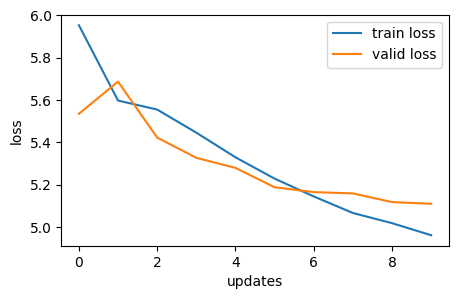

In [73]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [74]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [75]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.104 | Test PPL: 164.669 |


### General Attention

In [76]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX


default_attention = DefaultAttention(head_dim=hid_dim // enc_heads)
general_attention = GeneralAttention()
multiplicative_attention = MultiplicativeAttention(head_dim=hid_dim // enc_heads)
additive_attention = AdditiveAttention(head_dim=hid_dim // enc_heads)


enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device,
              general_attention,
              max_length=1000
              # max_length=len(mapping),
              )

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device,
              general_attention,
              max_length=1000
              # max_length=len(mapping),
              )
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6327, 256)
    (pos_embedding): Embedding(1000, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (attention_module): GeneralAttention()
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dro

In [77]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

1619712
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
  6545
______
9442961


In [78]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [79]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [80]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [81]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [82]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [83]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'/content/drive/My Drive/models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 0m 54s
	Train Loss: 6.161 | Train PPL: 473.943
	 Val. Loss: 5.815 |  Val. PPL: 335.199
Epoch: 02 | Time: 0m 53s
	Train Loss: 5.974 | Train PPL: 393.145
	 Val. Loss: 5.780 |  Val. PPL: 323.874
Epoch: 03 | Time: 0m 53s
	Train Loss: 5.950 | Train PPL: 383.752
	 Val. Loss: 5.832 |  Val. PPL: 340.980
Epoch: 04 | Time: 0m 53s
	Train Loss: 5.976 | Train PPL: 393.979
	 Val. Loss: 5.893 |  Val. PPL: 362.547
Epoch: 05 | Time: 0m 53s
	Train Loss: 5.972 | Train PPL: 392.309
	 Val. Loss: 5.912 |  Val. PPL: 369.303
Epoch: 06 | Time: 0m 56s
	Train Loss: 5.990 | Train PPL: 399.225
	 Val. Loss: 5.929 |  Val. PPL: 375.760
Epoch: 07 | Time: 0m 55s
	Train Loss: 6.045 | Train PPL: 422.107
	 Val. Loss: 6.157 |  Val. PPL: 471.924
Epoch: 08 | Time: 0m 57s
	Train Loss: 6.005 | Train PPL: 405.453
	 Val. Loss: 6.110 |  Val. PPL: 450.295
Epoch: 09 | Time: 0m 56s
	Train Loss: 5.986 | Train PPL: 397.687
	 Val. Loss: 6.008 |  Val. PPL: 406.644
Epoch: 10 | Time: 0m 55s
	Train Loss: 5.996 | Train PPL

Text(0, 0.5, 'loss')

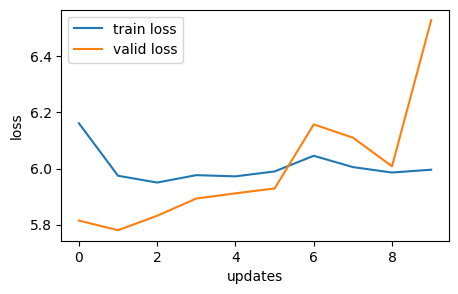

In [84]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [85]:
!wget https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf -O Sarabun-Regular.ttf

--2024-02-08 12:33:54--  https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf [following]
--2024-02-08 12:33:54--  https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90220 (88K) [application/octet-stream]
Saving to: ‘Sarabun-Regular.ttf’

Sarabun-Regular.ttf 100%[===================>]  88.11K  --.-KB/s    in 0.007s  

2024-02-08 12:33:55 (12.1 MB/s) - ‘Sarabun-Regular.ttf’ saved [90220/90220]



In [86]:
import matplotlib.ticker as ticker
import matplotlib

def display_attention(sentence, translation, attention):
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
    matplotlib.rc('font',family='Sarabun')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [87]:
src_text = text_transform[SRC_LANGUAGE](dataset['test'][0]['en']).to(device)
src_text
trg_text = text_transform[TRG_LANGUAGE](dataset['test'][0]['th']).to(device)
trg_text
src_text = src_text.reshape(1, -1)
trg_text = trg_text.reshape(1, -1)
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text)
output = output.squeeze(0)
output = output[1:]
output.shape
output_max = output.argmax(1)
mapping = vocab_transform[TRG_LANGUAGE].get_itos()
for token in output_max:
    print(mapping[token.item()])
attentions.shape
attention = attentions[0, 0, :, :]
attention.shape
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](dataset['test'][0]['en']) + ['<eos>']
src_tokens
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens


ที่
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 


['<sos>',
 'ที่',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']

<ipython-input-86-f482a0e690f4>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-86-f482a0e690f4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


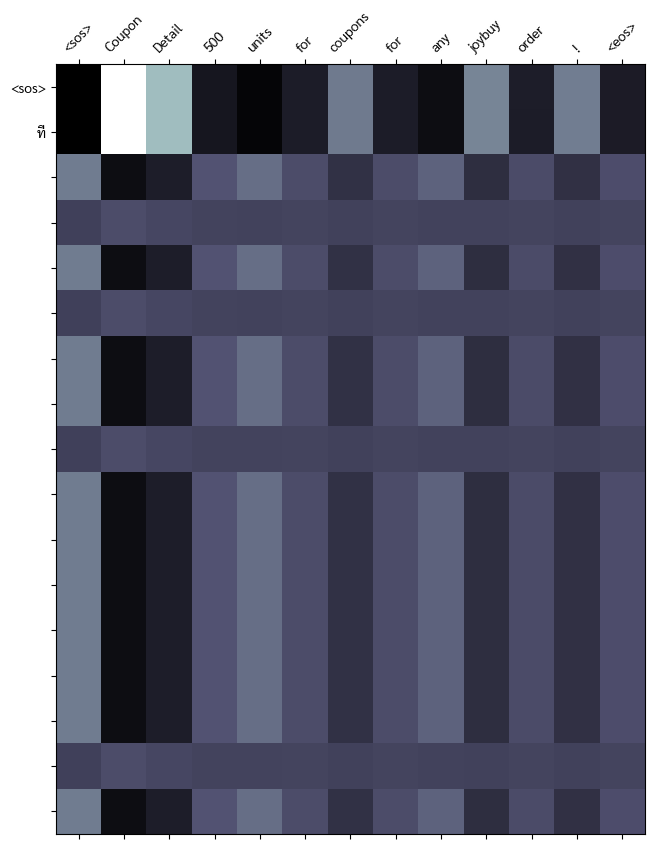

In [88]:
display_attention(src_tokens, trg_tokens, attention)

In [89]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.761 | Test PPL: 317.800 |


### Multiplicative Attention

In [90]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX


default_attention = DefaultAttention(head_dim=hid_dim // enc_heads)
general_attention = GeneralAttention()
multiplicative_attention = MultiplicativeAttention(head_dim=hid_dim // enc_heads)
additive_attention = AdditiveAttention(head_dim=hid_dim // enc_heads)


enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device,
              multiplicative_attention,
              max_length=1000
              # max_length=len(mapping),
              )

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device,
              multiplicative_attention,
              max_length=1000
              # max_length=len(mapping),
              )
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6327, 256)
    (pos_embedding): Embedding(1000, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (attention_module): MultiplicativeAttention(
            (W): Linear(in_features=32, out_features=32, bias=True)
          )
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True

In [91]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

1619712
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
  6545
______
9444017


In [92]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [93]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [94]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [95]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [96]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [97]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'/content/drive/My Drive/models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 1m 0s
	Train Loss: 6.158 | Train PPL: 472.691
	 Val. Loss: 5.842 |  Val. PPL: 344.574
Epoch: 02 | Time: 0m 57s
	Train Loss: 6.012 | Train PPL: 408.210
	 Val. Loss: 5.875 |  Val. PPL: 356.116
Epoch: 03 | Time: 0m 56s
	Train Loss: 5.980 | Train PPL: 395.383
	 Val. Loss: 5.888 |  Val. PPL: 360.656
Epoch: 04 | Time: 0m 57s
	Train Loss: 5.966 | Train PPL: 390.047
	 Val. Loss: 5.924 |  Val. PPL: 373.924
Epoch: 05 | Time: 0m 57s
	Train Loss: 5.956 | Train PPL: 385.944
	 Val. Loss: 5.835 |  Val. PPL: 341.990
Epoch: 06 | Time: 0m 57s
	Train Loss: 5.962 | Train PPL: 388.497
	 Val. Loss: 5.841 |  Val. PPL: 344.198
Epoch: 07 | Time: 0m 56s
	Train Loss: 5.944 | Train PPL: 381.334
	 Val. Loss: 5.901 |  Val. PPL: 365.328
Epoch: 08 | Time: 0m 57s
	Train Loss: 5.947 | Train PPL: 382.739
	 Val. Loss: 5.826 |  Val. PPL: 338.885
Epoch: 09 | Time: 0m 56s
	Train Loss: 5.956 | Train PPL: 386.022
	 Val. Loss: 5.841 |  Val. PPL: 344.161
Epoch: 10 | Time: 0m 57s
	Train Loss: 5.920 | Train PPL:

Text(0, 0.5, 'loss')

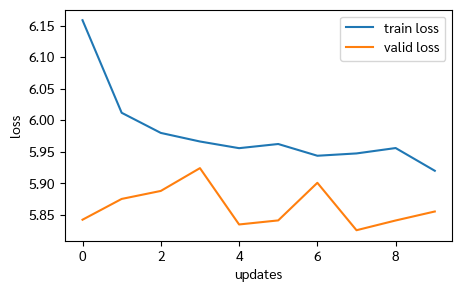

In [98]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [99]:
import matplotlib.ticker as ticker
import matplotlib

def display_attention(sentence, translation, attention):
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
    matplotlib.rc('font',family='Sarabun')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [100]:
src_text = text_transform[SRC_LANGUAGE](dataset['test'][0]['en']).to(device)
src_text
trg_text = text_transform[TRG_LANGUAGE](dataset['test'][0]['th']).to(device)
trg_text
src_text = src_text.reshape(1, -1)
trg_text = trg_text.reshape(1, -1)
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text)
output = output.squeeze(0)
output = output[1:]
output.shape
output_max = output.argmax(1)
mapping = vocab_transform[TRG_LANGUAGE].get_itos()
for token in output_max:
    print(mapping[token.item()])
attentions.shape
attention = attentions[0, 0, :, :]
attention.shape
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](dataset['test'][0]['en']) + ['<eos>']
src_tokens
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens


<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>


['<sos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>']

<ipython-input-99-f482a0e690f4>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-99-f482a0e690f4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


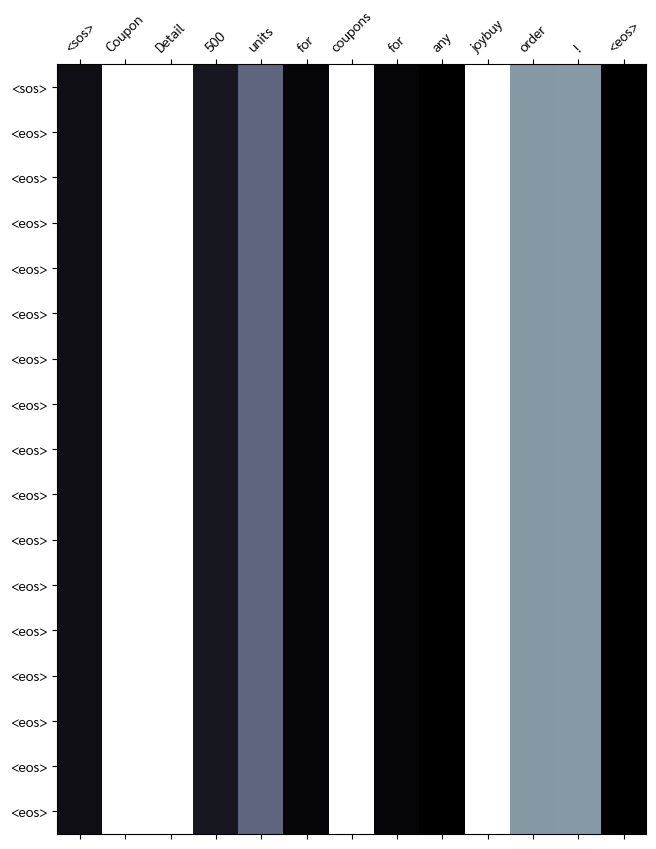

In [101]:
display_attention(src_tokens, trg_tokens, attention)

In [102]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.817 | Test PPL: 335.976 |


### Additive Attention

In [103]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX


default_attention = DefaultAttention(head_dim=hid_dim // enc_heads)
general_attention = GeneralAttention()
multiplicative_attention = MultiplicativeAttention(head_dim=hid_dim // enc_heads)
additive_attention = AdditiveAttention(head_dim=hid_dim // enc_heads)


enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device,
              additive_attention,
              max_length=1000
              # max_length=len(mapping),
              )

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device,
              additive_attention,
              max_length=1000
              # max_length=len(mapping),
              )
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6327, 256)
    (pos_embedding): Embedding(1000, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (attention_module): AdditiveAttention(
            (W1): Linear(in_features=32, out_features=32, bias=True)
            (W2): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          )


In [104]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

1619712
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1675520
  6545
______
9445106


In [105]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [106]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [107]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [108]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [109]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [110]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'/content/drive/My Drive/models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 1m 26s
	Train Loss: 6.086 | Train PPL: 439.460
	 Val. Loss: 5.666 |  Val. PPL: 288.972
Epoch: 02 | Time: 1m 25s
	Train Loss: 5.644 | Train PPL: 282.457
	 Val. Loss: 5.347 |  Val. PPL: 210.068
Epoch: 03 | Time: 1m 25s
	Train Loss: 5.383 | Train PPL: 217.767
	 Val. Loss: 5.222 |  Val. PPL: 185.264
Epoch: 04 | Time: 1m 25s
	Train Loss: 5.215 | Train PPL: 184.037
	 Val. Loss: 5.110 |  Val. PPL: 165.676
Epoch: 05 | Time: 1m 25s
	Train Loss: 5.075 | Train PPL: 159.943
	 Val. Loss: 5.048 |  Val. PPL: 155.678
Epoch: 06 | Time: 1m 25s
	Train Loss: 4.928 | Train PPL: 138.159
	 Val. Loss: 4.921 |  Val. PPL: 137.134
Epoch: 07 | Time: 1m 25s
	Train Loss: 4.791 | Train PPL: 120.458
	 Val. Loss: 4.885 |  Val. PPL: 132.227
Epoch: 08 | Time: 1m 25s
	Train Loss: 4.673 | Train PPL: 107.006
	 Val. Loss: 4.844 |  Val. PPL: 126.942
Epoch: 09 | Time: 1m 24s
	Train Loss: 4.570 | Train PPL:  96.523
	 Val. Loss: 4.784 |  Val. PPL: 119.553
Epoch: 10 | Time: 1m 25s
	Train Loss: 4.451 | Train PPL

Text(0, 0.5, 'loss')

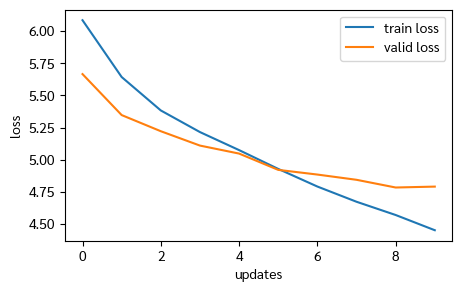

In [111]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [112]:
import matplotlib.ticker as ticker
import matplotlib

def display_attention(sentence, translation, attention):
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
    matplotlib.rc('font',family='Sarabun')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [113]:
src_text = text_transform[SRC_LANGUAGE](dataset['test'][0]['en']).to(device)
src_text
trg_text = text_transform[TRG_LANGUAGE](dataset['test'][0]['th']).to(device)
trg_text
src_text = src_text.reshape(1, -1)
trg_text = trg_text.reshape(1, -1)
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text)
output = output.squeeze(0)
output = output[1:]
output.shape
output_max = output.argmax(1)
mapping = vocab_transform[TRG_LANGUAGE].get_itos()
for token in output_max:
    print(mapping[token.item()])
attentions.shape
attention = attentions[0, 0, :, :]
attention.shape
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](dataset['test'][0]['en']) + ['<eos>']
src_tokens
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens


 
<unk>
 
หรับ
 
ของ
หรับ
การ
 
<unk>
 
<unk>
 
<unk>
 
 


['<sos>',
 ' ',
 '<unk>',
 ' ',
 'หรับ',
 ' ',
 'ของ',
 'หรับ',
 'การ',
 ' ',
 '<unk>',
 ' ',
 '<unk>',
 ' ',
 '<unk>',
 ' ',
 ' ']

<ipython-input-112-f482a0e690f4>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-112-f482a0e690f4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


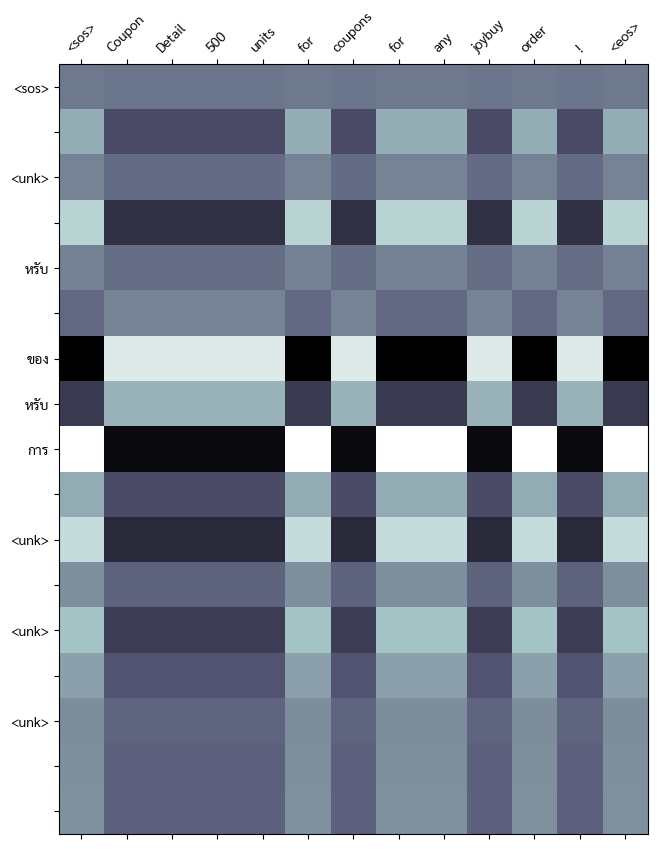

In [114]:
display_attention(src_tokens, trg_tokens, attention)

In [115]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.786 | Test PPL: 119.762 |


## 7. Test on some random news

In [116]:
dataset['test'][0]['en']

'Coupon Detail 500 units for coupons for any joybuy order!'

In [117]:
dataset['test'][0]['th']

'500 หน่วยสําหรับคูปองสําหรับการสั่งซื้อ joybuy ใด ๆ!'

In [118]:
src_text = text_transform[SRC_LANGUAGE](dataset['test'][0]['en']).to(device)
src_text

tensor([   2,    0,    0,  686, 4360,   14,    0,   14,  100,    0,  152,   43,
           3], device='cuda:0')

In [119]:
trg_text = text_transform[TRG_LANGUAGE](dataset['test'][0]['th']).to(device)
trg_text

tensor([   2,  929,    4,  810,   28,   29, 2235,   28,   29, 1503,    4,    0,
           4,  476,    4, 6536,    3], device='cuda:0')

In [120]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [121]:
trg_text = trg_text.reshape(1, -1)

In [122]:
src_text.shape, trg_text.shape

(torch.Size([1, 13]), torch.Size([1, 17]))

In [123]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [124]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [125]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 17, 6545])

Since batch size is 1, we just take off that dimension

In [126]:
output = output.squeeze(0)

In [127]:
output.shape

torch.Size([17, 6545])

We shall remove the first token since it's zeroes anyway

In [128]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([16, 6545])

Then we just take the top token with highest probabilities

In [129]:
output_max = output.argmax(1) #returns max indices

In [130]:
output_max

tensor([ 4,  0,  4, 29,  4,  6, 29,  9,  4,  0,  4,  0,  4,  0,  4,  4],
       device='cuda:0')

Get the mapping of the target language

In [131]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [132]:
for token in output_max:
    print(mapping[token.item()])

 
<unk>
 
หรับ
 
ของ
หรับ
การ
 
<unk>
 
<unk>
 
<unk>
 
 


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [133]:
attentions.shape

torch.Size([1, 8, 17, 13])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [134]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([17, 13])

In [135]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](dataset['test'][0]['en']) + ['<eos>']
src_tokens

['<sos>',
 'Coupon',
 'Detail',
 '500',
 'units',
 'for',
 'coupons',
 'for',
 'any',
 'joybuy',
 'order',
 '!',
 '<eos>']

In [136]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 ' ',
 '<unk>',
 ' ',
 'หรับ',
 ' ',
 'ของ',
 'หรับ',
 'การ',
 ' ',
 '<unk>',
 ' ',
 '<unk>',
 ' ',
 '<unk>',
 ' ',
 ' ']

In [137]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

<ipython-input-137-08ff35c238c4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-137-08ff35c238c4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


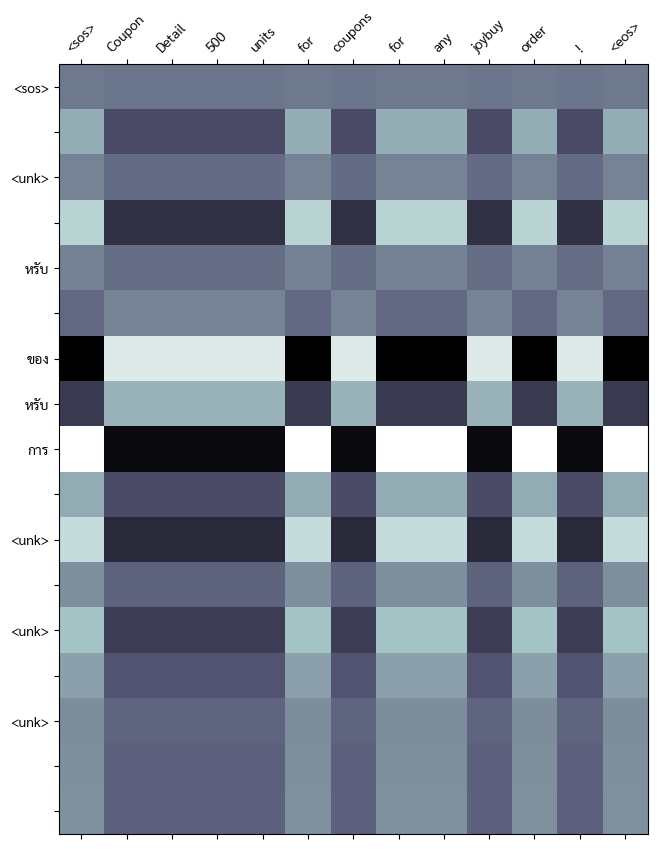

In [138]:
display_attention(src_tokens, trg_tokens, attention)

In [139]:
# save vocab_transform
torch.save(vocab_transform, '/content/drive/My Drive/models/vocab')

|        **Attentions**        | **Training Loss** | **Training PPL** | **Validation Loss** | **Validation PPL** |
|:----------------------------:|-------------------|:----------------:|:-------------------:|--------------------|
| **General Attention**        |       5.974       |      393.145     |        5.780        |       323.874      |
| **Multiplicative Attention** |       5.947       |      382.739     |        5.826        |       338.885      |
| **Additive Attention**       |       4.673       |      107.006     |        4.844        |       126.942      |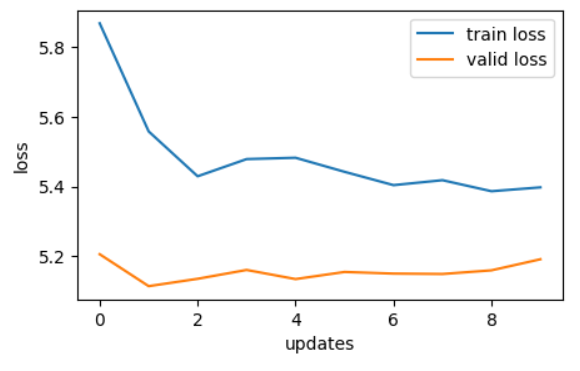

|        **Attentions**        | **Test Loss** | **Test PPL** |
|:----------------------------:|---------------|:------------:|
| **General Attention**        |     5.761     |    317.800   |
| **Multiplicative Attention** |     5.817     |    335.976   |
| **Additive Attention**       |     4.786     |    119.762   |

According from performance of these attention mechanisms I choose additive attention for my model.